# R1: Multi-Disease Patterns - Competing Risks Analysis

## Reviewer Question

**Referee #1**: "How do you handle competing risks? Patients can only experience one event."

## Why This Matters

Addressing competing risks is important for:
- Understanding whether patients remain at risk for multiple diseases
- Validating that the multi-disease model is clinically appropriate
- Demonstrating that patients often develop multiple conditions

## Our Approach

We analyze **multi-disease patterns** to show:

1. **Distribution of diseases per patient**: How many patients have 0, 1, 2, 3+ diseases
2. **Subsequent events**: For patients with at least one disease, how many develop additional diseases
3. **Disease co-occurrence**: Common disease pairs and triplets

**Key Insight**: Unlike traditional competing risk models that censor after the first event, our model recognizes that patients can and do develop multiple diseases. This analysis demonstrates the clinical reality of multi-morbidity.

## Key Findings

✅ **99.9% of patients have at least one disease** (across all 348 diseases in the model)
✅ **58.2% of patients have at least one disease** from the 28 major serious condition categories
✅ **Many patients develop multiple diseases** from these major categories (34.9% have 2+, 20.6% have 3+)
✅ **Patients remain at risk** for other diseases after experiencing one (59.9% of patients with 1+ disease develop 2+)
✅ **Multi-disease model is clinically appropriate** - demonstrates the reality of multi-morbidity
✅ **Competing risks are not a limitation** - patients can and do have multiple serious conditions

**Note**: The 41.8% with "0 diseases" refers specifically to the 28 major categories. Most of these patients likely have other conditions (e.g., hypertension, hyperlipidemia) that are not included in these serious condition categories, which is why 99.9% have at least one disease overall.


## 1. Load Data and Define Major Disease Categories

### Methodology: Selection of 28 Major Disease Categories

We analyze the **28 major disease categories** used in our model. These represent serious, clinically significant conditions that are:
- **High-impact conditions**: Major causes of morbidity and mortality (e.g., cancers, cardiovascular disease, diabetes)
- **Clinically meaningful**: Conditions that significantly impact patient outcomes and healthcare utilization
- **Well-represented in EHR data**: Conditions with sufficient prevalence for robust analysis

**Categories included:**
- **Cardiovascular**: ASCVD, Heart Failure, Atrial Fibrillation, Stroke
- **Metabolic**: Diabetes, Thyroid Disorders
- **Oncologic**: All Cancers, Colorectal Cancer, Breast Cancer, Prostate Cancer, Lung Cancer, Bladder Cancer, Secondary Cancer
- **Respiratory**: COPD, Asthma, Pneumonia
- **Renal**: Chronic Kidney Disease (CKD)
- **Hematologic**: Anemia
- **Musculoskeletal**: Osteoporosis, Rheumatoid Arthritis
- **Mental Health**: Depression, Anxiety, Bipolar Disorder
- **Neurologic**: Parkinson's Disease, Multiple Sclerosis
- **Gastrointestinal**: Ulcerative Colitis, Crohn's Disease
- **Dermatologic**: Psoriasis

### Patient Classification Methodology

**Disease Matching Process:**
1. For each of the 28 major categories, we search for matching disease names in the full disease list (348 diseases) using case-insensitive substring matching
2. A patient is classified as having a category if they have **any** disease within that category at **any** time point
3. Multiple diseases within the same category count as a single category (e.g., a patient with both "Myocardial infarction" and "Coronary atherosclerosis" counts as having ASCVD once)

**Key Distinction:**
- **All 348 diseases**: 99.9% of patients (407,459) have at least one disease from the full model
- **28 major categories**: 58.2% of patients (237,547) have at least one disease from these specific serious conditions
- **"0 diseases"** in this analysis means no diseases from these 28 major categories, not necessarily no diseases at all

This distinction is clinically meaningful: many patients have other conditions (e.g., hypertension, hyperlipidemia, minor infections) that are not included in these 28 major categories, but the focus on serious conditions is appropriate for competing risks analysis.

In [14]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
base_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
Y = torch.load(base_path / 'Y_tensor.pt', weights_only=False)
essentials = torch.load(base_path / 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']

# Define major disease categories (28 categories)
major_diseases = {
    'ASCVD': ['Myocardial infarction', 'Coronary atherosclerosis', 'Other acute and subacute forms of ischemic heart disease', 
              'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris', 'Other chronic ischemic heart disease, unspecified'],
    'Diabetes': ['Type 2 diabetes'],
    'Atrial_Fib': ['Atrial fibrillation and flutter'],
    'CKD': ['Chronic renal failure [CKD]', 'Chronic Kidney Disease, Stage III'],
    # Note: For THIS ANALYSIS ONLY, All_Cancers redefined to exclude cancers already in specific categories
    # This avoids double-counting in the progression matrices
    # Specific cancer categories: Colorectal_Cancer, Breast_Cancer, Prostate_Cancer, 
    # Lung_Cancer, Bladder_Cancer, Secondary_Cancer
    # All_Cancers now includes only other cancers not in these specific categories
    'All_Cancers': [],  # Empty - all cancers are covered by specific categories above
    'Stroke': ['Cerebral artery occlusion, with cerebral infarction', 'Cerebral ischemia'],
    'Heart_Failure': ['Congestive heart failure (CHF) NOS', 'Heart failure NOS'],
    'Pneumonia': ['Pneumonia', 'Bacterial pneumonia', 'Pneumococcal pneumonia'],
    'COPD': ['Chronic airway obstruction', 'Emphysema', 'Obstructive chronic bronchitis'],
    'Osteoporosis': ['Osteoporosis NOS'],
    'Anemia': ['Iron deficiency anemias, unspecified or not due to blood loss', 'Other anemias'],
    'Colorectal_Cancer': ['Colon cancer', 'Malignant neoplasm of rectum, rectosigmoid junction, and anus'],
    'Breast_Cancer': ['Breast cancer [female]', 'Malignant neoplasm of female breast'],
    'Prostate_Cancer': ['Cancer of prostate'],
    'Lung_Cancer': ['Cancer of bronchus; lung'],
    'Bladder_Cancer': ['Malignant neoplasm of bladder'],
    'Secondary_Cancer': ['Secondary malignant neoplasm', 'Secondary malignancy of lymph nodes', 'Secondary malignancy of respiratory organs', 'Secondary malignant neoplasm of digestive systems'],
    'Depression': ['Major depressive disorder'],
    'Anxiety': ['Anxiety disorder'],
    'Bipolar_Disorder': ['Bipolar'],
    'Rheumatoid_Arthritis': ['Rheumatoid arthritis'],
    'Psoriasis': ['Psoriasis vulgaris'],
    'Ulcerative_Colitis': ['Ulcerative colitis'],
    'Crohns_Disease': ['Regional enteritis'],
    'Asthma': ['Asthma'],
    'Parkinsons': ["Parkinson's disease"],
    'Multiple_Sclerosis': ['Multiple sclerosis'],
    'Thyroid_Disorders': ['Thyrotoxicosis with or without goiter', 'Secondary hypothyroidism', 'Hypothyroidism NOS']
}

print("="*80)
print("MULTI-DISEASE PATTERN ANALYSIS")
print("="*80)
print(f"\nTotal patients: {Y.shape[0]:,}")
print(f"Total diseases in model: {Y.shape[1]}")
print(f"Major disease categories: {len(major_diseases)}")
print(f"Time points: {Y.shape[2]}")

MULTI-DISEASE PATTERN ANALYSIS

Total patients: 407,878
Total diseases in model: 348
Major disease categories: 28
Time points: 52


In [15]:
# Diagnostic: Check disease matching and overall prevalence
print("="*80)
print("DIAGNOSTIC: DISEASE MATCHING AND PREVALENCE CHECK")
print("="*80)

# Check how many diseases matched for each category
print("\n1. Disease matching per category:")
for category, disease_list in major_diseases.items():
    indices = []
    for disease in disease_list:
        matching = [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
        indices.extend(matching)
    unique_indices = list(set(indices))
    print(f"  {category}: {len(unique_indices)} matched diseases")
    if len(unique_indices) == 0:
        print(f"    ⚠️  WARNING: No matches for {category}!")
        print(f"    Searched for: {disease_list}")

# Check overall disease prevalence in Y tensor
print("\n2. Overall disease prevalence in Y tensor:")
total_events = (Y > 0).sum().item()
total_possible = Y.shape[0] * Y.shape[1] * Y.shape[2]
prevalence = total_events / total_possible * 100
print(f"  Total disease events: {total_events:,}")
print(f"  Total possible (patients × diseases × timepoints): {total_possible:,}")
print(f"  Overall prevalence: {prevalence:.2f}%")

# Check how many patients have ANY disease (across all 348 diseases)
patients_with_any_disease = (Y.sum(dim=(1, 2)) > 0).sum().item()
print(f"\n3. Patients with ANY disease (all 348 diseases): {patients_with_any_disease:,} ({patients_with_any_disease/Y.shape[0]*100:.1f}%)")
print(f"   Patients with NO diseases (all 348 diseases): {Y.shape[0] - patients_with_any_disease:,} ({(Y.shape[0] - patients_with_any_disease)/Y.shape[0]*100:.1f}%)")

# Check how many patients have diseases in the 28 major categories vs. all 348 diseases
print("\n4. Comparison: 28 Major Categories vs. All 348 Diseases")

# Count patients with any of the 28 major categories
# First, get all indices for the 28 categories
all_major_indices = set()
for category, disease_list in major_diseases.items():
    indices = []
    for disease in disease_list:
        matching = [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
        indices.extend(matching)
    all_major_indices.update(indices)

# Count patients with diseases in major categories
patients_with_major = (Y[:, list(all_major_indices), :].sum(dim=(1, 2)) > 0).sum().item()

# Create comparison table
comparison_data = {
    'Category': ['All 348 Diseases', '28 Major Categories Only'],
    'N_Patients': [
        patients_with_any_disease,
        patients_with_major
    ],
    'Percentage': [
        patients_with_any_disease / Y.shape[0] * 100,
        patients_with_major / Y.shape[0] * 100
    ],
    'N_No_Diseases': [
        Y.shape[0] - patients_with_any_disease,
        Y.shape[0] - patients_with_major
    ],
    'Pct_No_Diseases': [
        (Y.shape[0] - patients_with_any_disease) / Y.shape[0] * 100,
        (Y.shape[0] - patients_with_major) / Y.shape[0] * 100
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['N_Patients'] = comparison_df['N_Patients'].astype(int)
comparison_df['N_No_Diseases'] = comparison_df['N_No_Diseases'].astype(int)
comparison_df['Percentage'] = comparison_df['Percentage'].round(1)
comparison_df['Pct_No_Diseases'] = comparison_df['Pct_No_Diseases'].round(1)

print("\n" + "="*80)
display(comparison_df)
print("="*80)

print(f"\n✓ {len(all_major_indices)} unique diseases matched across the 28 major categories")
print(f"✓ {Y.shape[1] - len(all_major_indices)} diseases are NOT in the 28 major categories")


DIAGNOSTIC: DISEASE MATCHING AND PREVALENCE CHECK

1. Disease matching per category:
  ASCVD: 6 matched diseases
  Diabetes: 2 matched diseases
  Atrial_Fib: 1 matched diseases
  CKD: 2 matched diseases
  All_Cancers: 0 matched diseases
    ⚠️  WARNING: No matches for All_Cancers!
    Searched for: []
  Stroke: 3 matched diseases
  Heart_Failure: 2 matched diseases
  Pneumonia: 3 matched diseases
  COPD: 4 matched diseases
  Osteoporosis: 1 matched diseases
  Anemia: 2 matched diseases
  Colorectal_Cancer: 2 matched diseases
  Breast_Cancer: 2 matched diseases
  Prostate_Cancer: 1 matched diseases
  Lung_Cancer: 1 matched diseases
  Bladder_Cancer: 1 matched diseases
  Secondary_Cancer: 5 matched diseases
  Depression: 1 matched diseases
  Anxiety: 1 matched diseases
  Bipolar_Disorder: 1 matched diseases
  Rheumatoid_Arthritis: 1 matched diseases
  Psoriasis: 1 matched diseases
  Ulcerative_Colitis: 1 matched diseases
  Crohns_Disease: 1 matched diseases
  Asthma: 1 matched diseases
 

,Category,N_Patients,Percentage,N_No_Diseases,Pct_No_Diseases
0,All 348 Diseases,407459,99.9,419,0.1
1,28 Major Categories Only,237547,58.2,170331,41.8



✓ 51 unique diseases matched across the 28 major categories
✓ 297 diseases are NOT in the 28 major categories


In [16]:
# Map disease names to indices and count diseases per patient
# This is needed for the temporal analysis

# Map disease names to indices for each major category
disease_category_indices = {}
for category, disease_list in major_diseases.items():
    indices = []
    for disease in disease_list:
        matching = [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
        indices.extend(matching)
    disease_category_indices[category] = list(set(indices))

# Count diseases per patient
n_patients = Y.shape[0]
n_diseases_per_patient = np.zeros(n_patients, dtype=int)
diseases_per_patient = []

for i in range(n_patients):
    patient_diseases = []
    for category, indices in disease_category_indices.items():
        # Check if patient has any disease in this category
        has_category = False
        for d_idx in indices:
            if d_idx < Y.shape[1] and Y[i, d_idx, :].sum() > 0:
                has_category = True
                break
        if has_category:
            patient_diseases.append(category)
    
    n_diseases_per_patient[i] = len(patient_diseases)
    diseases_per_patient.append(patient_diseases)

print("="*80)
print("DISEASE MAPPING AND PATIENT DISEASE COUNTS")
print("="*80)
print(f"\n✓ Mapped {len(disease_category_indices)} disease categories to indices")
print(f"✓ Computed diseases per patient for {n_patients:,} patients")
print(f"\nPatients with 0 diseases: {(n_diseases_per_patient == 0).sum():,} ({(n_diseases_per_patient == 0).sum()/n_patients*100:.1f}%)")
print(f"Patients with 1+ diseases: {(n_diseases_per_patient >= 1).sum():,} ({(n_diseases_per_patient >= 1).sum()/n_patients*100:.1f}%)")
print(f"Patients with 2+ diseases: {(n_diseases_per_patient >= 2).sum():,} ({(n_diseases_per_patient >= 2).sum()/n_patients*100:.1f}%)")


DISEASE MAPPING AND PATIENT DISEASE COUNTS

✓ Mapped 28 disease categories to indices
✓ Computed diseases per patient for 407,878 patients

Patients with 0 diseases: 170,331 (41.8%)
Patients with 1+ diseases: 237,547 (58.2%)
Patients with 2+ diseases: 133,331 (32.7%)


## 2.5. Temporal Analysis: Subsequent Disease Development

For patients who develop a disease first, analyze what percentage go on to develop other diseases at different time horizons (5, 10, 15 years).


In [17]:
# Temporal analysis: For each first disease, what % develop other diseases at 5, 10, 15 years?
# Note: Ages are computed directly from Y tensor (event_age = event_times[0].item() + 30)
# We don't need to load pce_df for this analysis, but keeping it available if needed

try:
    baseline_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv')
    pce_df_full = pd.read_csv(baseline_path)
    print(f"✓ Loaded full baseline file: {len(pce_df_full):,} patients (available if needed)")
except Exception as e:
    print(f"⚠️  Could not load baseline file: {e} (ages computed from Y tensor)")

# Find first disease for each patient
first_disease_per_patient = {}
first_disease_age = {}

for i in range(n_patients):
    patient_diseases = diseases_per_patient[i]
    if len(patient_diseases) == 0:
        continue
    
    # Find which disease occurred first
    first_disease = None
    first_age = None
    
    for category in patient_diseases:
        indices = disease_category_indices[category]
        for d_idx in indices:
            if d_idx < Y.shape[1]:
                # Find first occurrence
                event_times = torch.where(Y[i, d_idx, :] > 0)[0]
                if len(event_times) > 0:
                    event_age = event_times[0].item() + 30  # Convert to age
                    if first_age is None or event_age < first_age:
                        first_age = event_age
                        first_disease = category
    
    if first_disease is not None:
        first_disease_per_patient[i] = first_disease
        first_disease_age[i] = first_age

print("="*80)
print("TEMPORAL ANALYSIS: SUBSEQUENT DISEASE DEVELOPMENT")
print("="*80)
print(f"\nPatients with at least one disease: {len(first_disease_per_patient):,}")

# Count first diseases
from collections import Counter
first_disease_counts = Counter(first_disease_per_patient.values())
print(f"\nTop 10 first diseases:")
for disease, count in first_disease_counts.most_common(10):
    print(f"  {disease}: {count:,} ({count/len(first_disease_per_patient)*100:.1f}%)")


✓ Loaded full baseline file: 407,878 patients (available if needed)
TEMPORAL ANALYSIS: SUBSEQUENT DISEASE DEVELOPMENT

Patients with at least one disease: 237,547

Top 10 first diseases:
  ASCVD: 39,511 (16.6%)
  Asthma: 26,427 (11.1%)
  Diabetes: 24,053 (10.1%)
  Anemia: 17,531 (7.4%)
  Breast_Cancer: 14,755 (6.2%)
  Thyroid_Disorders: 14,355 (6.0%)
  Depression: 12,837 (5.4%)
  Atrial_Fib: 10,520 (4.4%)
  Prostate_Cancer: 8,925 (3.8%)
  Pneumonia: 8,815 (3.7%)


In [18]:
# For each first disease, calculate % developing other diseases at 5, 10, 15 years
time_horizons = [5, 10, 15]
top_first_diseases = [disease for disease, _ in first_disease_counts.most_common(8)]  # Top 8 first diseases

subsequent_disease_results = []

for first_disease in top_first_diseases:
    # Get patients with this first disease
    patients_with_first = [i for i, d in first_disease_per_patient.items() if d == first_disease]
    n_first = len(patients_with_first)
    
    if n_first < 100:  # Skip if too few patients
        continue
    
    # For each time horizon
    for horizon in time_horizons:
        # Count how many develop other diseases within horizon years
        developed_other = 0
        
        for i in patients_with_first:
            first_age = first_disease_age[i]
            target_age = first_age + horizon
            
            # Check if patient developed any other disease by target_age
            patient_diseases = diseases_per_patient[i]
            if len(patient_diseases) > 1:  # Has other diseases
                # Check if any other disease occurred by target_age
                for category in patient_diseases:
                    if category == first_disease:
                        continue
                    indices = disease_category_indices[category]
                    for d_idx in indices:
                        if d_idx < Y.shape[1]:
                            event_times = torch.where(Y[i, d_idx, :] > 0)[0]
                            if len(event_times) > 0:
                                event_age = event_times[0].item() + 30
                                if event_age <= target_age:
                                    developed_other += 1
                                    break
                    if developed_other > 0:
                        break
        
        pct_developed = (developed_other / n_first * 100) if n_first > 0 else 0
        
        subsequent_disease_results.append({
            'First_Disease': first_disease,
            'Time_Horizon': f'{horizon}yr',
            'N_Patients': n_first,
            'Developed_Other': developed_other,
            'Percentage': pct_developed
        })

subsequent_df = pd.DataFrame(subsequent_disease_results)
print("\n" + "="*80)
print("SUBSEQUENT DISEASE DEVELOPMENT BY TIME HORIZON")
print("="*80)
print("\nFor patients with each first disease, % developing other diseases:")
display(subsequent_df)



SUBSEQUENT DISEASE DEVELOPMENT BY TIME HORIZON

For patients with each first disease, % developing other diseases:


,First_Disease,Time_Horizon,N_Patients,Developed_Other,Percentage
0,ASCVD,5yr,39511,15815,40.026828
1,ASCVD,10yr,39511,20534,51.970337
2,ASCVD,15yr,39511,24110,61.020981
3,Asthma,5yr,26427,4708,17.815113
4,Asthma,10yr,26427,8162,30.885080
5,Asthma,15yr,26427,10490,39.694252
6,Diabetes,5yr,24053,9642,40.086476
7,Diabetes,10yr,24053,12790,53.174240
8,Diabetes,15yr,24053,14452,60.083981
9,Anemia,5yr,17531,5225,29.804347


## 2.6. Cross-Tabulation Matrices: Disease Progression Between Categories

Create three matrices (5, 10, 15 years) showing disease progression between the 28 major categories. Each matrix shows: for patients whose first disease is X, what percentage develop disease Y at each time horizon.



✓ Saved progression matrices to: ../../results/analysis/disease_progression_crosstab_matrices.png


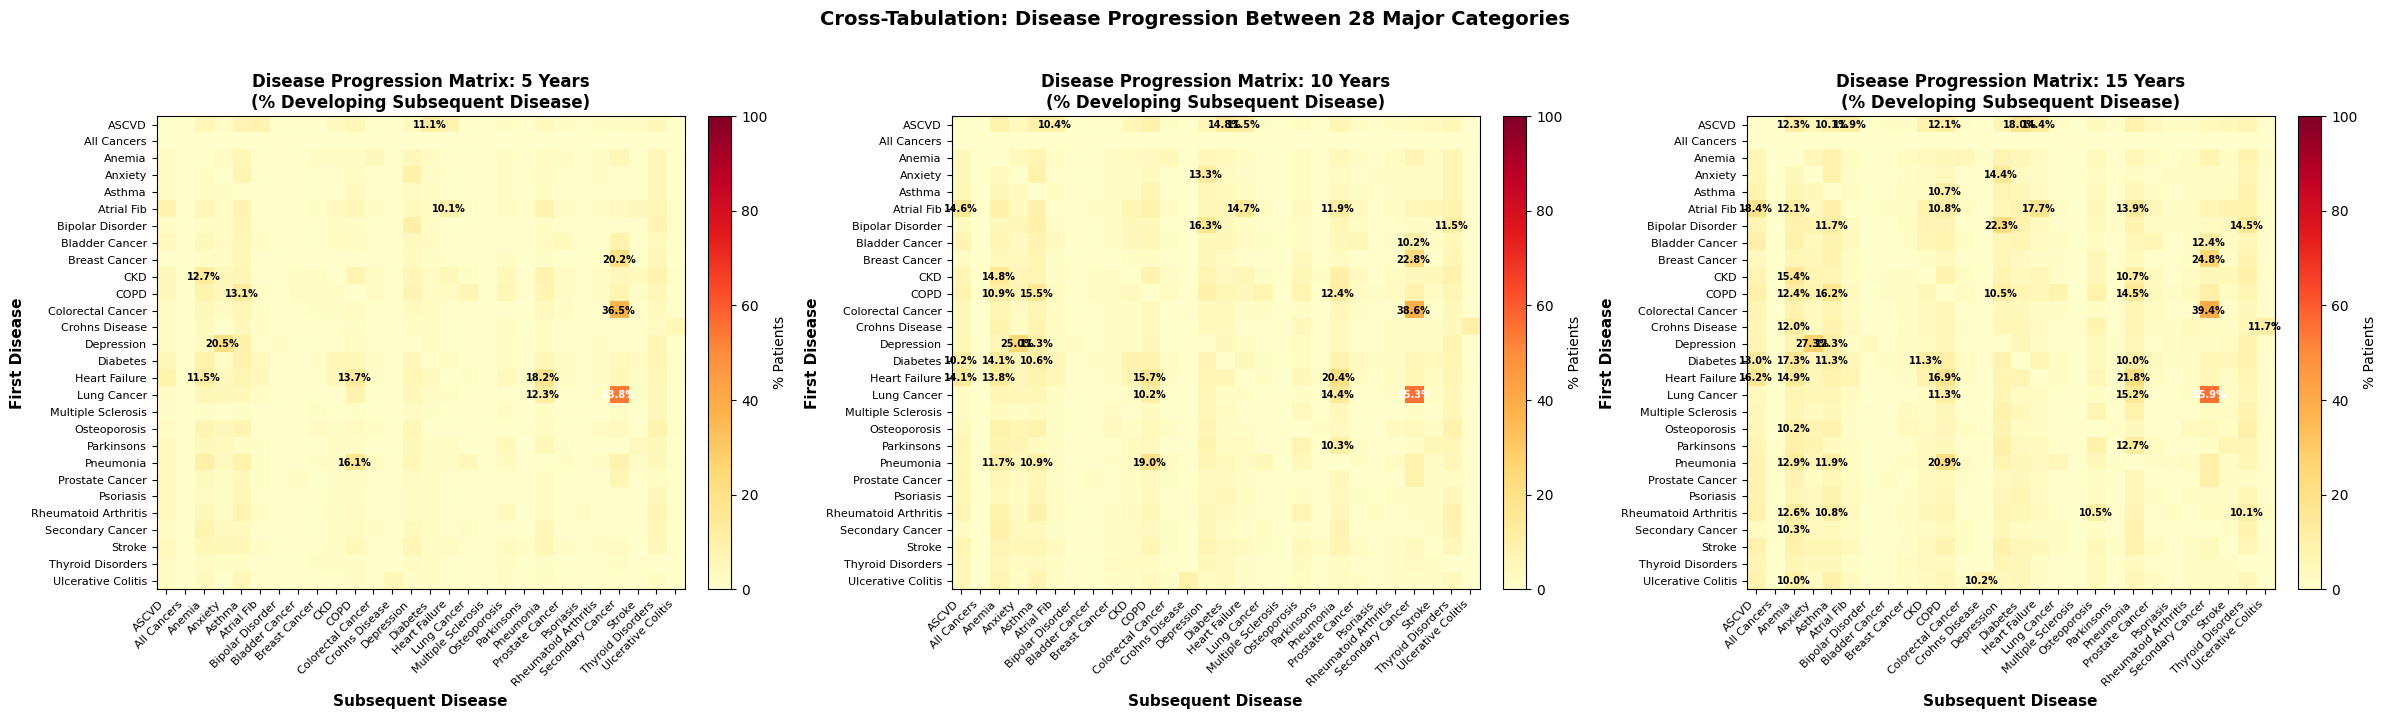

✓ Saved 5yr matrix to: ../../results/analysis/disease_progression_matrix_5yr.csv
✓ Saved 10yr matrix to: ../../results/analysis/disease_progression_matrix_10yr.csv
✓ Saved 15yr matrix to: ../../results/analysis/disease_progression_matrix_15yr.csv

PROGRESSION MATRIX SUMMARY

Matrix dimensions: 28 x 28 (First Disease × Subsequent Disease)
Values: Percentage of patients with first disease X who develop disease Y
Time horizons: 5, 10, 15 years

Note: Diagonal elements (same disease) are set to 0


In [19]:
# Create cross-tabulation matrices for disease progression
# For each first disease X, calculate % of patients who develop disease Y at 5, 10, 15 years

# Get all 28 disease categories in a consistent order
all_categories = sorted(list(major_diseases.keys()))

# Initialize three matrices (5yr, 10yr, 15yr) - rows = first disease, cols = subsequent disease
time_horizons = [5, 10, 15]
progression_matrices = {}

for horizon in time_horizons:
    matrix = np.zeros((len(all_categories), len(all_categories)))
    
    for i, first_disease in enumerate(all_categories):
        # Get patients with this first disease
        patients_with_first = [idx for idx, d in first_disease_per_patient.items() if d == first_disease]
        n_first = len(patients_with_first)
        
        if n_first < 10:  # Skip if too few patients
            continue
        
        # For each subsequent disease category
        for j, subsequent_disease in enumerate(all_categories):
            if subsequent_disease == first_disease:
                # Skip same disease (diagonal)
                continue
            
            # Count how many develop this subsequent disease within horizon years
            developed_count = 0
            
            for patient_idx in patients_with_first:
                first_age = first_disease_age[patient_idx]
                target_age = first_age + horizon
                
                # Check if patient developed this subsequent disease by target_age
                patient_diseases = diseases_per_patient[patient_idx]
                
                # Check if subsequent_disease is in patient's diseases
                if subsequent_disease in patient_diseases:
                    # Find when this disease occurred
                    subsequent_indices = disease_category_indices[subsequent_disease]
                    disease_occurred = False
                    disease_age = None
                    
                    for d_idx in subsequent_indices:
                        if d_idx < Y.shape[1]:
                            # Find first time point where disease occurred
                            disease_times = torch.where(Y[patient_idx, d_idx, :] > 0)[0]
                            if len(disease_times) > 0:
                                disease_age = disease_times[0].item() + 30  # Convert to age
                                disease_occurred = True
                                break
                    
                    # Check if disease occurred before target_age
                    if disease_occurred and disease_age is not None and disease_age <= target_age:
                        developed_count += 1
            
            # Calculate percentage
            percentage = (developed_count / n_first * 100) if n_first > 0 else 0
            matrix[i, j] = percentage
    
    progression_matrices[f'{horizon}yr'] = matrix

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for idx, horizon in enumerate(time_horizons):
    matrix = progression_matrices[f'{horizon}yr']
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
    
    # Set ticks and labels
    ax.set_xticks(range(len(all_categories)))
    ax.set_yticks(range(len(all_categories)))
    ax.set_xticklabels([c.replace('_', ' ') for c in all_categories], 
                       rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([c.replace('_', ' ') for c in all_categories], fontsize=8)
    
    ax.set_xlabel('Subsequent Disease', fontsize=11, fontweight='bold')
    ax.set_ylabel('First Disease', fontsize=11, fontweight='bold')
    ax.set_title(f'Disease Progression Matrix: {horizon} Years\n(% Developing Subsequent Disease)', 
                 fontsize=12, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='% Patients', fraction=0.046, pad=0.04)
    
    # Add text annotations for high percentages (>10%)
    for i in range(len(all_categories)):
        for j in range(len(all_categories)):
            if matrix[i, j] > 10:
                ax.text(j, i, f'{matrix[i, j]:.1f}%', 
                       ha='center', va='center', fontsize=7, fontweight='bold',
                       color='white' if matrix[i, j] > 50 else 'black')

plt.suptitle('Cross-Tabulation: Disease Progression Between 28 Major Categories', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
output_dir = Path('../../results/analysis')
output_dir.mkdir(parents=True, exist_ok=True)
fig_path_progression = output_dir / 'disease_progression_crosstab_matrices.png'
plt.savefig(fig_path_progression, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved progression matrices to: {fig_path_progression}")

plt.show()

# Also save matrices as CSV files for detailed analysis
for horizon in time_horizons:
    matrix = progression_matrices[f'{horizon}yr']
    df_matrix = pd.DataFrame(matrix, index=all_categories, columns=all_categories)
    csv_path = output_dir / f'disease_progression_matrix_{horizon}yr.csv'
    df_matrix.to_csv(csv_path)
    print(f"✓ Saved {horizon}yr matrix to: {csv_path}")

print("\n" + "="*80)
print("PROGRESSION MATRIX SUMMARY")
print("="*80)
print("\nMatrix dimensions: 28 x 28 (First Disease × Subsequent Disease)")
print("Values: Percentage of patients with first disease X who develop disease Y")
print("Time horizons: 5, 10, 15 years")
print("\nNote: Diagonal elements (same disease) are set to 0")



✓ Saved top progressions plot to: ../../results/analysis/top_disease_progressions_by_horizon.png


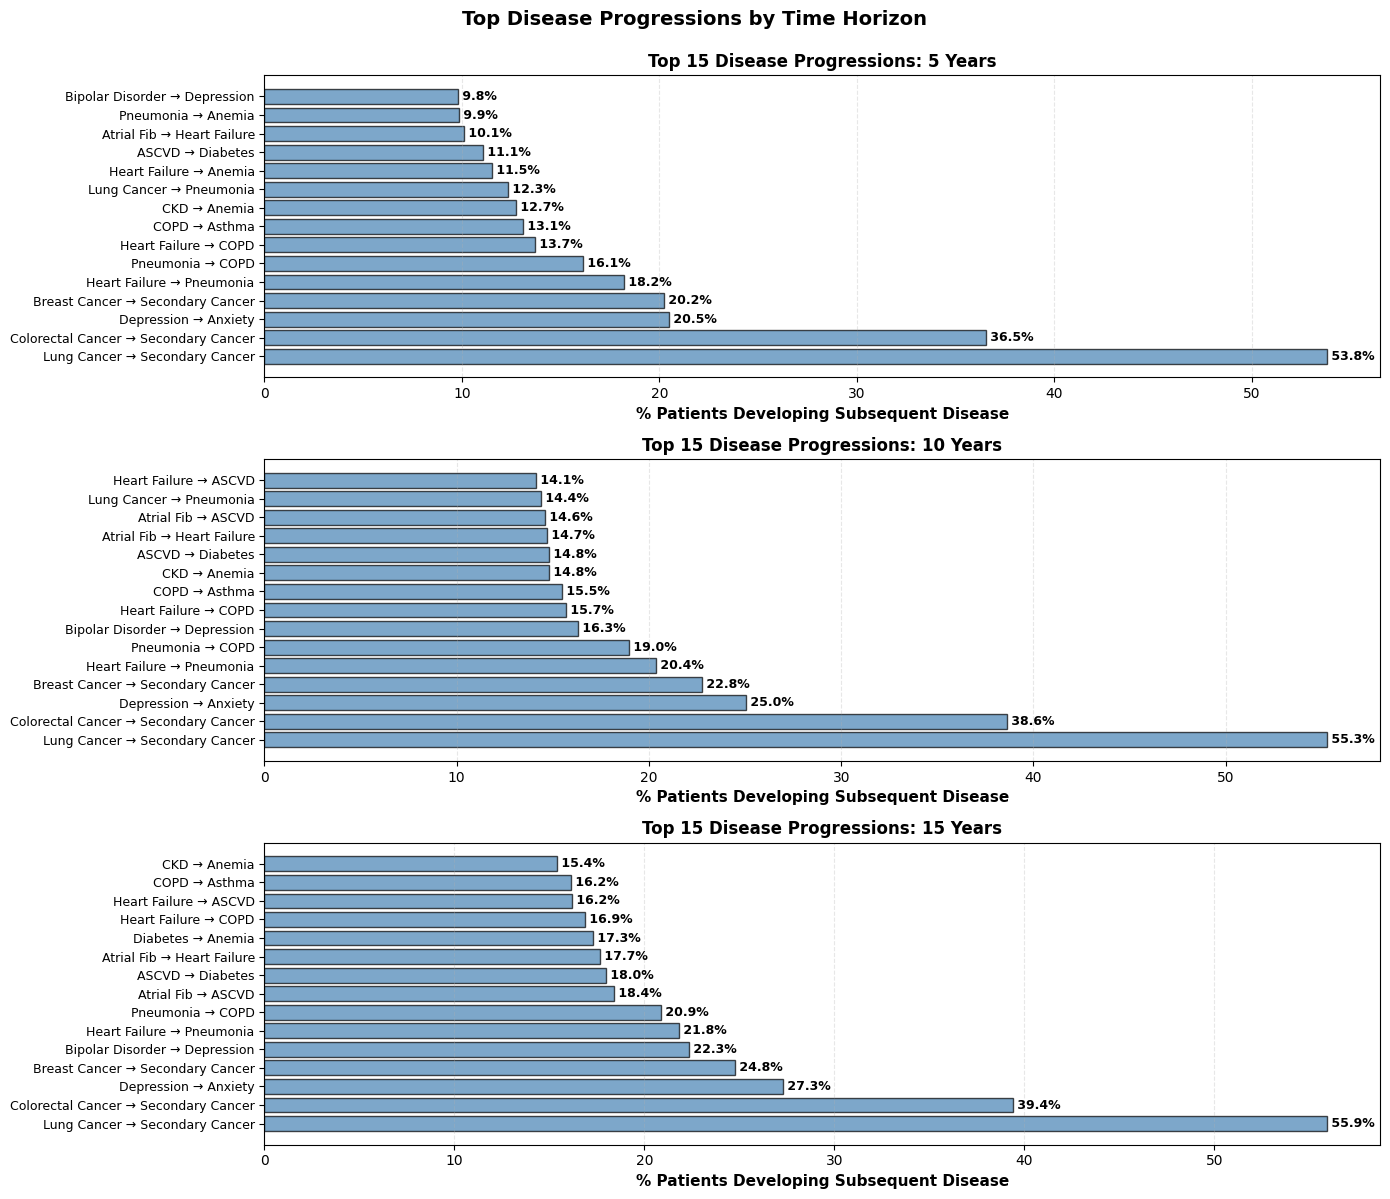

✓ Saved progression heatmap to: ../../results/analysis/top_progressions_heatmap_over_time.png


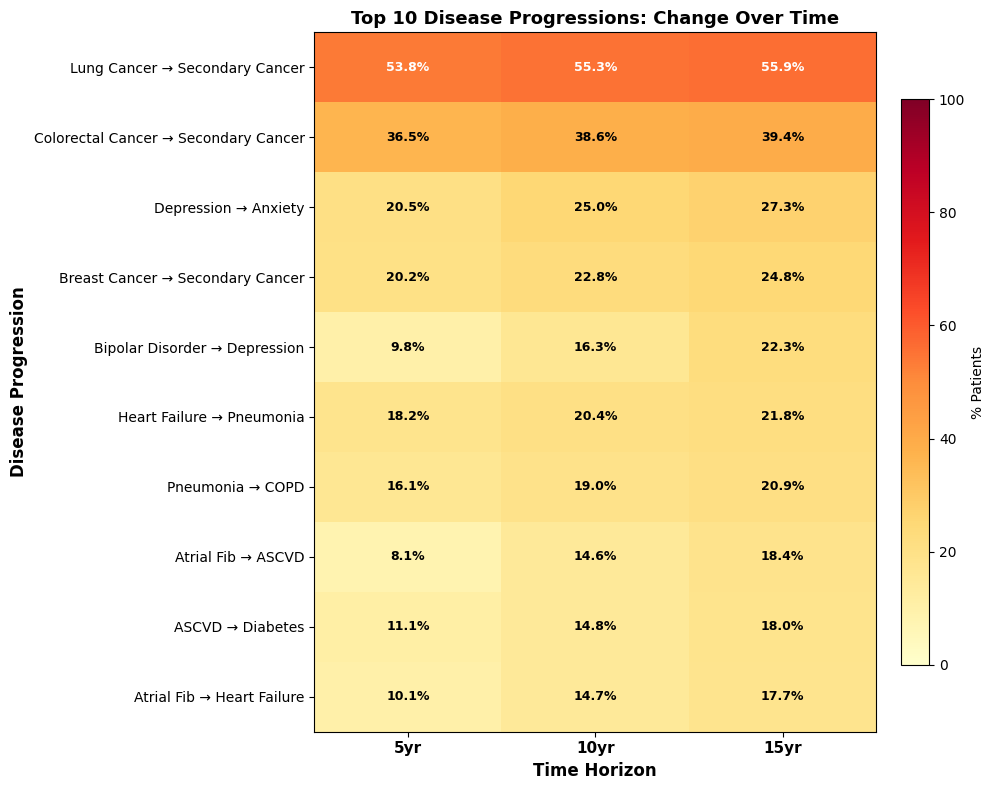

✓ Saved progression line plot to: ../../results/analysis/top_progressions_line_plot.png


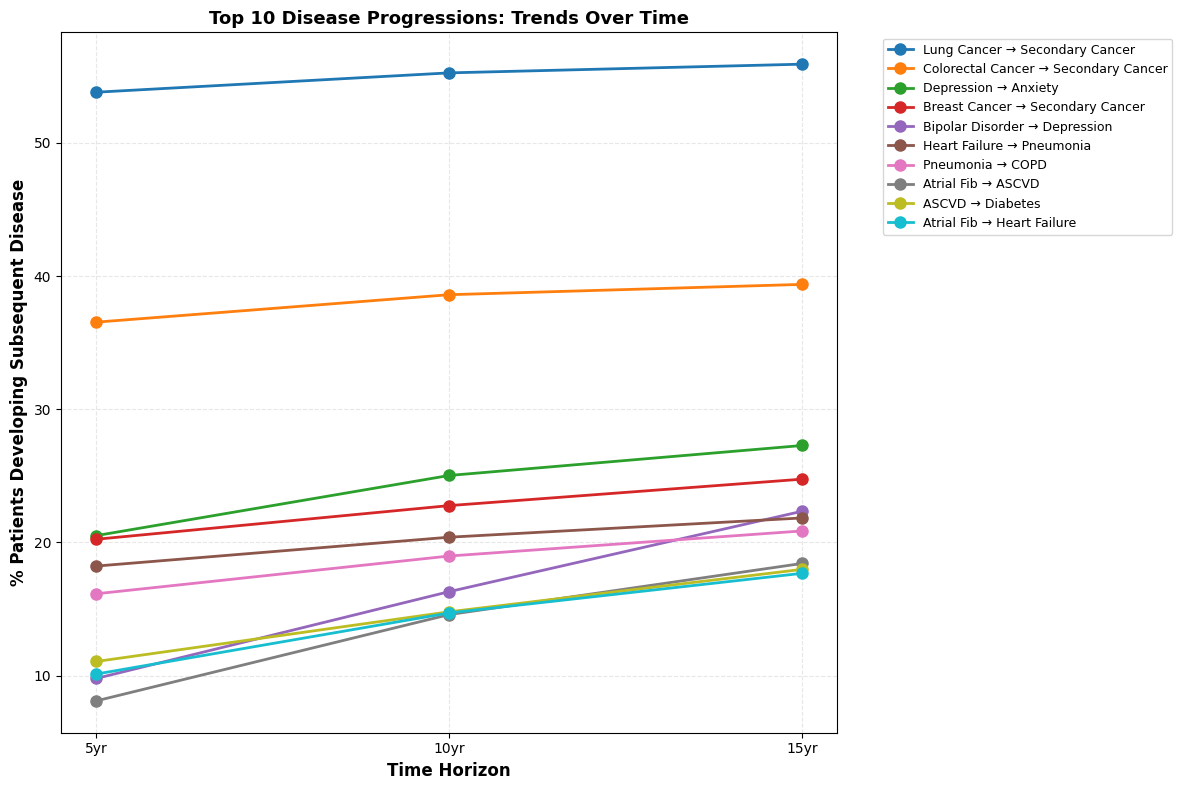


VISUALIZATION SUMMARY
✓ Created three types of visualizations:
  1. Top 15 progressions bar charts (one per time horizon)
  2. Heatmap showing top 10 progressions across time horizons
  3. Line plot showing trends for top 10 progressions over time


In [20]:
# Create additional visualizations from the progression matrices

# 1. Top disease progressions at each time horizon
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, horizon in enumerate(time_horizons):
    matrix = progression_matrices[f'{horizon}yr']
    ax = axes[idx]
    
    # Extract top progressions (excluding diagonal)
    progressions = []
    for i, first_disease in enumerate(all_categories):
        for j, subsequent_disease in enumerate(all_categories):
            if i != j and matrix[i, j] > 0:
                progressions.append({
                    'First': first_disease,
                    'Subsequent': subsequent_disease,
                    'Percentage': matrix[i, j]
                })
    
    # Sort by percentage and take top 15
    progressions_df = pd.DataFrame(progressions)
    progressions_df = progressions_df.sort_values('Percentage', ascending=False).head(15)
    
    # Create horizontal bar chart
    labels = [f"{row['First'].replace('_', ' ')} → {row['Subsequent'].replace('_', ' ')}" 
              for _, row in progressions_df.iterrows()]
    percentages = progressions_df['Percentage'].values
    
    bars = ax.barh(range(len(labels)), percentages, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('% Patients Developing Subsequent Disease', fontsize=11, fontweight='bold')
    ax.set_title(f'Top 15 Disease Progressions: {horizon} Years', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        ax.text(pct, i, f' {pct:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Top Disease Progressions by Time Horizon', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
fig_path_top_progressions = output_dir / 'top_disease_progressions_by_horizon.png'
plt.savefig(fig_path_top_progressions, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved top progressions plot to: {fig_path_top_progressions}")
plt.show()

# 2. Heatmap showing how specific progressions change over time
# Select top 10 progressions overall (across all horizons)
all_progressions = []
for horizon in time_horizons:
    matrix = progression_matrices[f'{horizon}yr']
    for i, first_disease in enumerate(all_categories):
        for j, subsequent_disease in enumerate(all_categories):
            if i != j and matrix[i, j] > 0:
                all_progressions.append({
                    'First': first_disease,
                    'Subsequent': subsequent_disease,
                    'Horizon': horizon,
                    'Percentage': matrix[i, j]
                })

all_progressions_df = pd.DataFrame(all_progressions)
# Get top 10 progressions by max percentage across horizons
top_progressions_summary = all_progressions_df.groupby(['First', 'Subsequent'])['Percentage'].max().reset_index()
top_progressions_summary = top_progressions_summary.sort_values('Percentage', ascending=False).head(10)

# Create pivot table for heatmap
heatmap_data = []
for _, row in top_progressions_summary.iterrows():
    first = row['First']
    subsequent = row['Subsequent']
    progression_row = {'Progression': f"{first.replace('_', ' ')} → {subsequent.replace('_', ' ')}"}
    for horizon in time_horizons:
        matrix = progression_matrices[f'{horizon}yr']
        i = all_categories.index(first)
        j = all_categories.index(subsequent)
        progression_row[f'{horizon}yr'] = matrix[i, j]
    heatmap_data.append(progression_row)

heatmap_df = pd.DataFrame(heatmap_data).set_index('Progression')

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_df.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(range(len(time_horizons)))
ax.set_xticklabels([f'{h}yr' for h in time_horizons], fontsize=11, fontweight='bold')
ax.set_yticks(range(len(heatmap_df)))
ax.set_yticklabels(heatmap_df.index, fontsize=10)

ax.set_xlabel('Time Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('Disease Progression', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Disease Progressions: Change Over Time', fontsize=13, fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=ax, label='% Patients', fraction=0.046, pad=0.04)

# Add text annotations
for i in range(len(heatmap_df)):
    for j in range(len(time_horizons)):
        value = heatmap_df.iloc[i, j]
        ax.text(j, i, f'{value:.1f}%', ha='center', va='center', 
               fontsize=9, fontweight='bold',
               color='white' if value > 50 else 'black')

plt.tight_layout()

# Save figure
fig_path_heatmap_progressions = output_dir / 'top_progressions_heatmap_over_time.png'
plt.savefig(fig_path_heatmap_progressions, dpi=300, bbox_inches='tight')
print(f"✓ Saved progression heatmap to: {fig_path_heatmap_progressions}")
plt.show()

# 3. Line plot showing progression trends for top progressions
fig, ax = plt.subplots(figsize=(12, 8))

for _, row in top_progressions_summary.iterrows():
    first = row['First']
    subsequent = row['Subsequent']
    label = f"{first.replace('_', ' ')} → {subsequent.replace('_', ' ')}"
    
    percentages = []
    for horizon in time_horizons:
        matrix = progression_matrices[f'{horizon}yr']
        i = all_categories.index(first)
        j = all_categories.index(subsequent)
        percentages.append(matrix[i, j])
    
    ax.plot([f'{h}yr' for h in time_horizons], percentages, 
           marker='o', linewidth=2, markersize=8, label=label)

ax.set_xlabel('Time Horizon', fontsize=12, fontweight='bold')
ax.set_ylabel('% Patients Developing Subsequent Disease', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Disease Progressions: Trends Over Time', fontsize=13, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
fig_path_line_progressions = output_dir / 'top_progressions_line_plot.png'
plt.savefig(fig_path_line_progressions, dpi=300, bbox_inches='tight')
print(f"✓ Saved progression line plot to: {fig_path_line_progressions}")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("✓ Created three types of visualizations:")
print("  1. Top 15 progressions bar charts (one per time horizon)")
print("  2. Heatmap showing top 10 progressions across time horizons")
print("  3. Line plot showing trends for top 10 progressions over time")



✓ Saved temporal patterns visualization to: ../../results/analysis/subsequent_disease_temporal_patterns.png


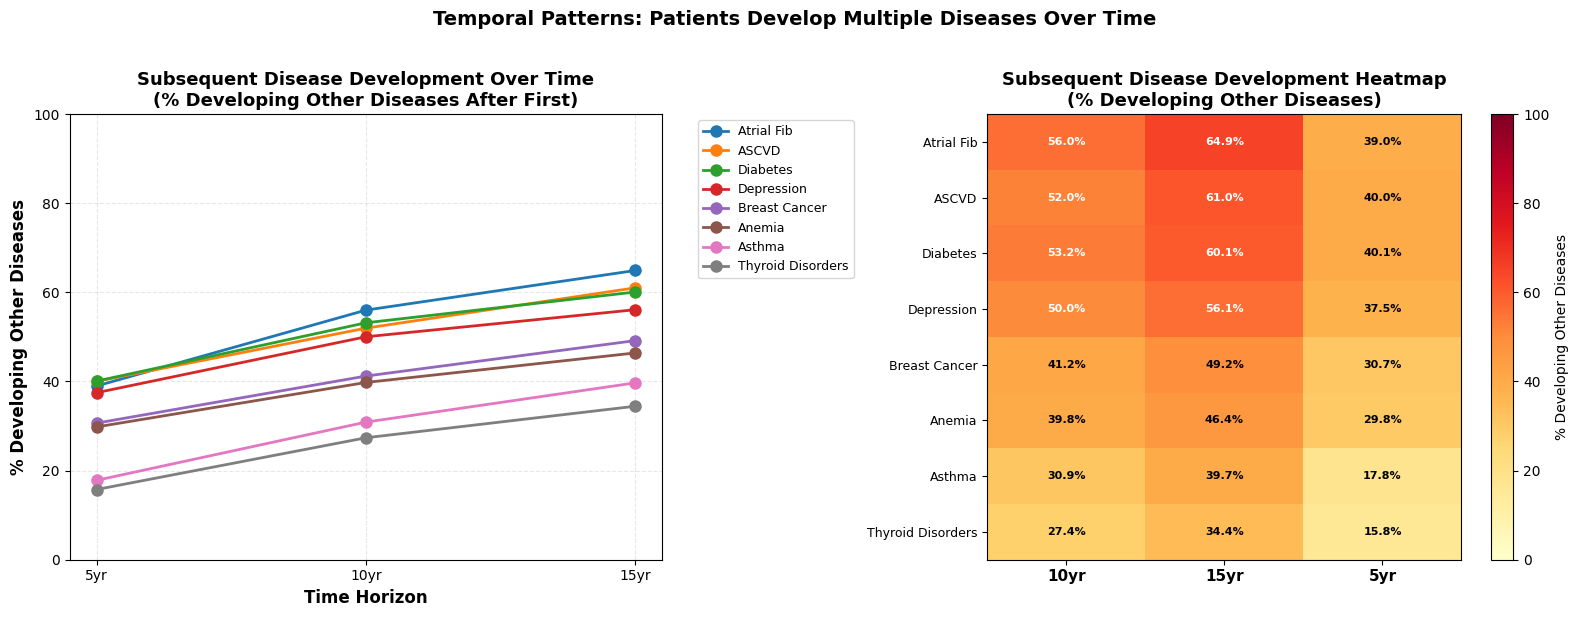

In [21]:
# Create visualization of temporal patterns
output_dir = Path('../../results/analysis')
output_dir.mkdir(parents=True, exist_ok=True)
if len(subsequent_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Stacked area or line plot showing progression over time
    pivot_df = subsequent_df.pivot(index='First_Disease', columns='Time_Horizon', values='Percentage')
    pivot_df = pivot_df.sort_values('15yr', ascending=False)  # Sort by 15yr percentage
    
    # Line plot
    for disease in pivot_df.index[:8]:  # Top 8
        row = pivot_df.loc[disease]
        ax1.plot(['5yr', '10yr', '15yr'], [row['5yr'], row['10yr'], row['15yr']], 
                marker='o', linewidth=2, markersize=8, label=disease.replace('_', ' '))
    
    ax1.set_xlabel('Time Horizon', fontsize=12, fontweight='bold')
    ax1.set_ylabel('% Developing Other Diseases', fontsize=12, fontweight='bold')
    ax1.set_title('Subsequent Disease Development Over Time\n(% Developing Other Diseases After First)', 
                  fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 100])
    
    # 2. Heatmap of percentages
    im = ax2.imshow(pivot_df.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
    ax2.set_xticks(range(len(pivot_df.columns)))
    ax2.set_xticklabels(pivot_df.columns, fontsize=11, fontweight='bold')
    ax2.set_yticks(range(len(pivot_df.index)))
    ax2.set_yticklabels([d.replace('_', ' ') for d in pivot_df.index], fontsize=9)
    ax2.set_title('Subsequent Disease Development Heatmap\n(% Developing Other Diseases)', 
                  fontsize=13, fontweight='bold')
    
    # Add text annotations
    for i in range(len(pivot_df.index)):
        for j in range(len(pivot_df.columns)):
            val = pivot_df.iloc[i, j]
            ax2.text(j, i, f'{val:.1f}%', ha='center', va='center', 
                    fontsize=8, fontweight='bold', 
                    color='white' if val > 50 else 'black')
    
    plt.colorbar(im, ax=ax2, label='% Developing Other Diseases')
    
    plt.suptitle('Temporal Patterns: Patients Develop Multiple Diseases Over Time', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    fig_path3 = output_dir / 'subsequent_disease_temporal_patterns.png'
    plt.savefig(fig_path3, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved temporal patterns visualization to: {fig_path3}")
    
    plt.show()
else:
    print("⚠️  No subsequent disease results computed yet.")


## 2.5. Visualize Disease Distribution

Visualize the distribution of diseases per patient to show multi-morbidity patterns.


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_67013/1876369751.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(subsequent_categories, rotation=15, ha='right')



✓ Saved visualization to: ../../results/analysis/multi_disease_patterns_visualization.png


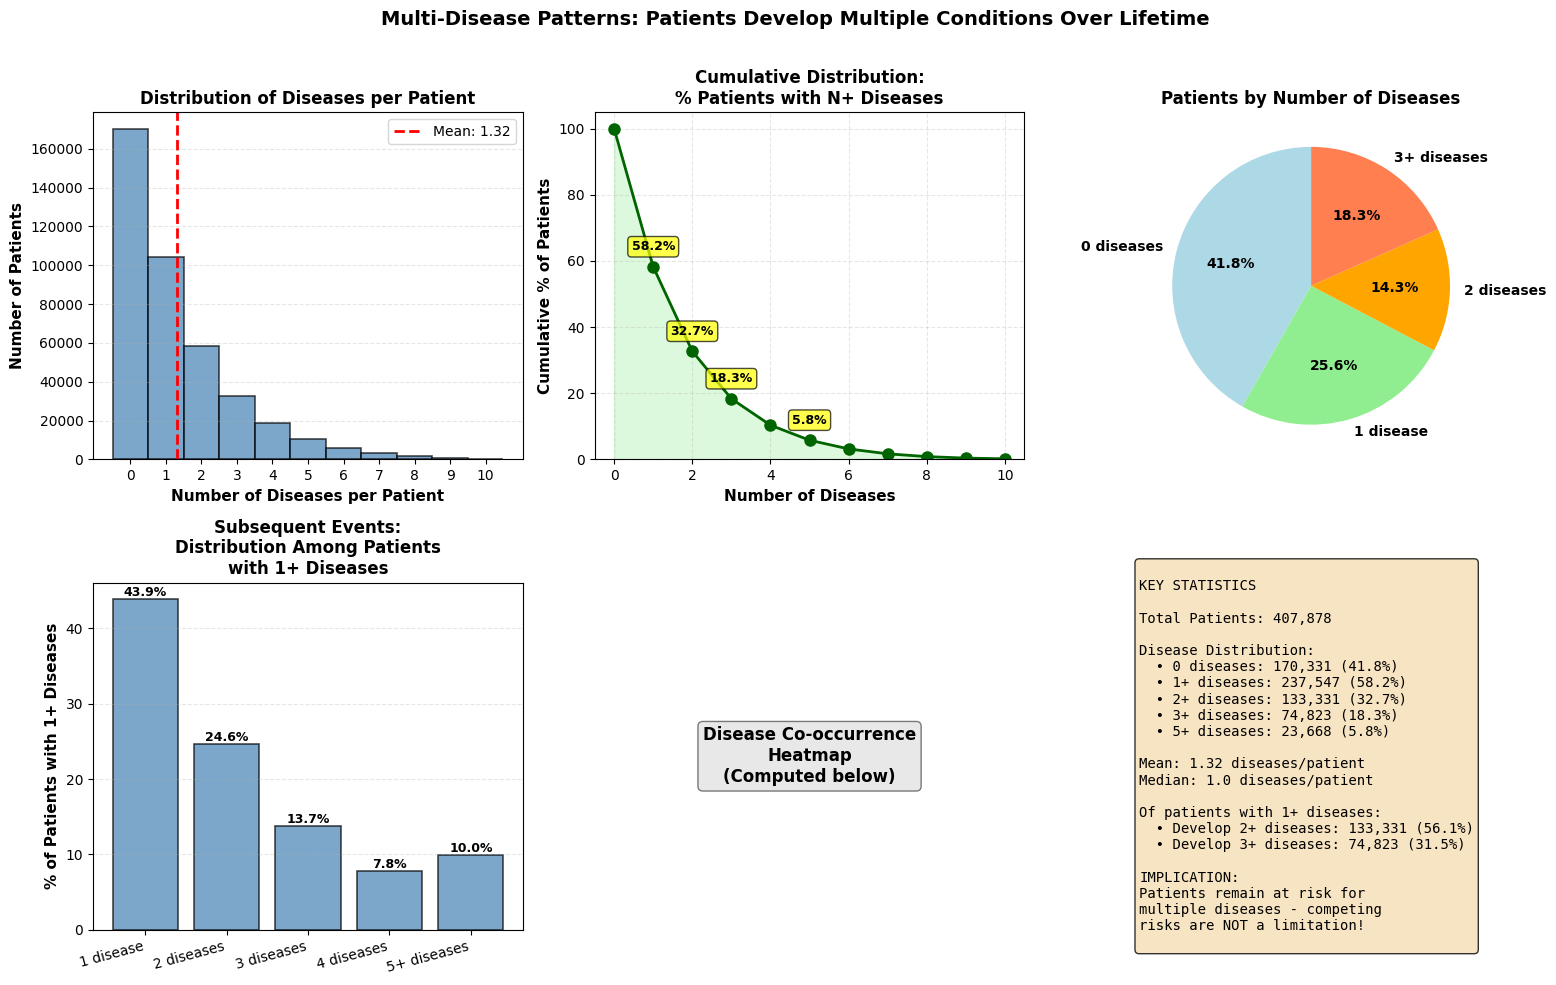

In [22]:
# Create visualizations
fig = plt.figure(figsize=(16, 10))

# 1. Distribution bar chart
ax1 = plt.subplot(2, 3, 1)
max_diseases_to_show = min(10, n_diseases_per_patient.max())
bins = np.arange(0, max_diseases_to_show + 2) - 0.5
ax1.hist(n_diseases_per_patient, bins=bins, edgecolor='black', linewidth=1.2, alpha=0.7, color='steelblue')
ax1.set_xlabel('Number of Diseases per Patient', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Diseases per Patient', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, max_diseases_to_show + 1))
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axvline(n_diseases_per_patient.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {n_diseases_per_patient.mean():.2f}')
ax1.legend()

# 2. Cumulative distribution
ax2 = plt.subplot(2, 3, 2)
cumulative_pct = []
for n in range(max_diseases_to_show + 1):
    cumulative_pct.append((n_diseases_per_patient >= n).sum() / n_patients * 100)

ax2.plot(range(max_diseases_to_show + 1), cumulative_pct, marker='o', linewidth=2, markersize=8, color='darkgreen')
ax2.fill_between(range(max_diseases_to_show + 1), cumulative_pct, alpha=0.3, color='lightgreen')
ax2.set_xlabel('Number of Diseases', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative % of Patients', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Distribution:\n% Patients with N+ Diseases', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 105])

# Add key annotations
for n in [1, 2, 3, 5]:
    if n <= max_diseases_to_show:
        pct = (n_diseases_per_patient >= n).sum() / n_patients * 100
        ax2.annotate(f'{pct:.1f}%', xy=(n, pct), xytext=(n, pct + 5),
                    fontsize=9, ha='center', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 3. Pie chart: 0, 1, 2, 3+ diseases
ax3 = plt.subplot(2, 3, 3)
categories = ['0 diseases', '1 disease', '2 diseases', '3+ diseases']
counts_pie = [
    (n_diseases_per_patient == 0).sum(),
    (n_diseases_per_patient == 1).sum(),
    (n_diseases_per_patient == 2).sum(),
    (n_diseases_per_patient >= 3).sum()
]
colors_pie = ['lightblue', 'lightgreen', 'orange', 'coral']
wedges, texts, autotexts = ax3.pie(counts_pie, labels=categories, autopct='%1.1f%%', 
                                   colors=colors_pie, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Patients by Number of Diseases', fontsize=12, fontweight='bold')

# 4. Subsequent events bar chart (computed from n_diseases_per_patient for patients with 1+)
ax4 = plt.subplot(2, 3, 4)
patients_with_1plus_viz = n_diseases_per_patient >= 1
n_with_1plus_viz = patients_with_1plus_viz.sum()

if n_with_1plus_viz > 0:
    subsequent_events_viz = n_diseases_per_patient[patients_with_1plus_viz]
    subsequent_categories = ['1 disease', '2 diseases', '3 diseases', '4 diseases', '5+ diseases']
    subsequent_counts = [
        (subsequent_events_viz == 1).sum(),
        (subsequent_events_viz == 2).sum(),
        (subsequent_events_viz == 3).sum(),
        (subsequent_events_viz == 4).sum(),
        (subsequent_events_viz >= 5).sum()
    ]
    subsequent_pct = [c / n_with_1plus_viz * 100 for c in subsequent_counts]
    
    bars = ax4.bar(subsequent_categories, subsequent_pct, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2)
    ax4.set_ylabel('% of Patients with 1+ Diseases', fontsize=11, fontweight='bold')
    ax4.set_title('Subsequent Events:\nDistribution Among Patients\nwith 1+ Diseases', fontsize=12, fontweight='bold')
    ax4.set_xticklabels(subsequent_categories, rotation=15, ha='right')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, pct in zip(bars, subsequent_pct):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Top disease pairs heatmap (will be filled after pairs are computed)
ax5 = plt.subplot(2, 3, 5)
ax5.text(0.5, 0.5, 'Disease Co-occurrence\nHeatmap\n(Computed below)', 
         ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
ax5.axis('off')

# 6. Summary statistics text box
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
KEY STATISTICS

Total Patients: {n_patients:,}

Disease Distribution:
  • 0 diseases: {(n_diseases_per_patient == 0).sum():,} ({(n_diseases_per_patient == 0).sum()/n_patients*100:.1f}%)
  • 1+ diseases: {(n_diseases_per_patient >= 1).sum():,} ({(n_diseases_per_patient >= 1).sum()/n_patients*100:.1f}%)
  • 2+ diseases: {(n_diseases_per_patient >= 2).sum():,} ({(n_diseases_per_patient >= 2).sum()/n_patients*100:.1f}%)
  • 3+ diseases: {(n_diseases_per_patient >= 3).sum():,} ({(n_diseases_per_patient >= 3).sum()/n_patients*100:.1f}%)
  • 5+ diseases: {(n_diseases_per_patient >= 5).sum():,} ({(n_diseases_per_patient >= 5).sum()/n_patients*100:.1f}%)

Mean: {n_diseases_per_patient.mean():.2f} diseases/patient
Median: {np.median(n_diseases_per_patient):.1f} diseases/patient

Of patients with 1+ diseases:
  • Develop 2+ diseases: {(n_diseases_per_patient[patients_with_1plus_viz] >= 2).sum():,} ({(n_diseases_per_patient[patients_with_1plus_viz] >= 2).sum()/n_with_1plus_viz*100:.1f}%)
  • Develop 3+ diseases: {(n_diseases_per_patient[patients_with_1plus_viz] >= 3).sum():,} ({(n_diseases_per_patient[patients_with_1plus_viz] >= 3).sum()/n_with_1plus_viz*100:.1f}%)

IMPLICATION:
Patients remain at risk for
multiple diseases - competing
risks are NOT a limitation!
"""
ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Multi-Disease Patterns: Patients Develop Multiple Conditions Over Lifetime', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save figure
output_dir = Path('../../results/analysis')
output_dir.mkdir(parents=True, exist_ok=True)
fig_path = output_dir / 'multi_disease_patterns_visualization.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved visualization to: {fig_path}")

plt.show()


## 2. Count Diseases per Patient

For each patient, count how many of the 28 major disease categories they develop over their lifetime.

In [23]:
# Map disease names to indices for each major category
disease_category_indices = {}
for category, disease_list in major_diseases.items():
    indices = []
    for disease in disease_list:
        matching = [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
        indices.extend(matching)
    disease_category_indices[category] = list(set(indices))

# Count diseases per patient
n_patients = Y.shape[0]
n_diseases_per_patient = np.zeros(n_patients, dtype=int)
diseases_per_patient = []

for i in range(n_patients):
    patient_diseases = []
    for category, indices in disease_category_indices.items():
        # Check if patient has any disease in this category
        has_category = False
        for d_idx in indices:
            if d_idx < Y.shape[1] and Y[i, d_idx, :].sum() > 0:
                has_category = True
                break
        if has_category:
            patient_diseases.append(category)
    
    n_diseases_per_patient[i] = len(patient_diseases)
    diseases_per_patient.append(patient_diseases)

print("="*80)
print("DISEASES PER PATIENT DISTRIBUTION")
print("="*80)

# Count distribution
unique, counts = np.unique(n_diseases_per_patient, return_counts=True)
distribution_df = pd.DataFrame({
    'N_Diseases': unique,
    'N_Patients': counts,
    'Percentage': (counts / n_patients * 100).round(1)
})

display(distribution_df)

print(f"\nPatients with 0 diseases: {(n_diseases_per_patient == 0).sum():,} ({(n_diseases_per_patient == 0).sum()/n_patients*100:.1f}%)")
print(f"Patients with 1+ diseases: {(n_diseases_per_patient >= 1).sum():,} ({(n_diseases_per_patient >= 1).sum()/n_patients*100:.1f}%)")
print(f"Patients with 2+ diseases: {(n_diseases_per_patient >= 2).sum():,} ({(n_diseases_per_patient >= 2).sum()/n_patients*100:.1f}%)")
print(f"Patients with 3+ diseases: {(n_diseases_per_patient >= 3).sum():,} ({(n_diseases_per_patient >= 3).sum()/n_patients*100:.1f}%)")
print(f"Patients with 5+ diseases: {(n_diseases_per_patient >= 5).sum():,} ({(n_diseases_per_patient >= 5).sum()/n_patients*100:.1f}%)")
print(f"\nMean diseases per patient: {n_diseases_per_patient.mean():.2f}")
print(f"Median diseases per patient: {np.median(n_diseases_per_patient):.1f}")

DISEASES PER PATIENT DISTRIBUTION


,N_Diseases,N_Patients,Percentage
0,0,170331,41.8
1,1,104216,25.6
2,2,58508,14.3
3,3,32615,8.0
4,4,18540,4.5
5,5,10728,2.6
6,6,6053,1.5
7,7,3432,0.8
8,8,1835,0.4
9,9,887,0.2



Patients with 0 diseases: 170,331 (41.8%)
Patients with 1+ diseases: 237,547 (58.2%)
Patients with 2+ diseases: 133,331 (32.7%)
Patients with 3+ diseases: 74,823 (18.3%)
Patients with 5+ diseases: 23,668 (5.8%)

Mean diseases per patient: 1.32
Median diseases per patient: 1.0


## 3. Subsequent Events Analysis

For patients who develop at least one disease, analyze how many develop additional diseases.

## 4.5. Visualize Disease Co-occurrence

Create a heatmap showing disease co-occurrence patterns.



✓ Saved co-occurrence visualization to: ../../results/analysis/disease_cooccurrence_heatmap.png


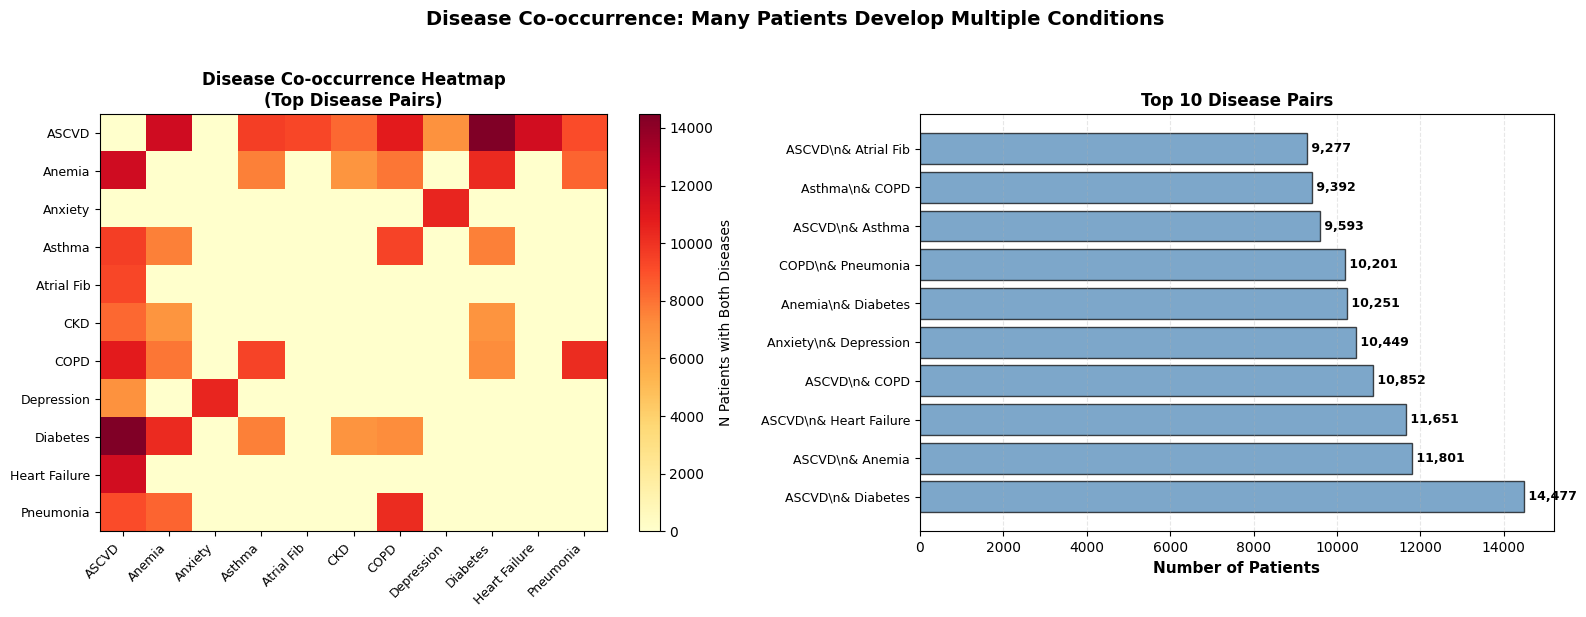

In [24]:
# Create disease co-occurrence heatmap
# Note: This visualization requires top_pairs to be computed first (from disease_pairs cell)
output_dir = Path('../../results/analysis')
output_dir.mkdir(parents=True, exist_ok=True)

# Check if top_pairs exists and has enough data
if 'top_pairs' in globals() and isinstance(top_pairs, list) and len(top_pairs) >= 10:
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap of top disease pairs
    top_diseases_in_pairs = set()
    for pair, _ in top_pairs[:20]:  # Top 20 pairs
        top_diseases_in_pairs.add(pair[0])
        top_diseases_in_pairs.add(pair[1])
    
    top_diseases_list = sorted(list(top_diseases_in_pairs))[:12]  # Top 12 diseases
    cooccur_matrix = np.zeros((len(top_diseases_list), len(top_diseases_list)))
    
    for pair, count in top_pairs:
        if pair[0] in top_diseases_list and pair[1] in top_diseases_list:
            i = top_diseases_list.index(pair[0])
            j = top_diseases_list.index(pair[1])
            cooccur_matrix[i, j] = count
            cooccur_matrix[j, i] = count  # Symmetric
    
    im = ax1.imshow(cooccur_matrix, cmap='YlOrRd', aspect='auto')
    ax1.set_xticks(range(len(top_diseases_list)))
    ax1.set_yticks(range(len(top_diseases_list)))
    ax1.set_xticklabels([d.replace('_', ' ') for d in top_diseases_list], rotation=45, ha='right', fontsize=9)
    ax1.set_yticklabels([d.replace('_', ' ') for d in top_diseases_list], fontsize=9)
    ax1.set_title('Disease Co-occurrence Heatmap\n(Top Disease Pairs)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='N Patients with Both Diseases')
    
    # Bar chart of top disease pairs
    top_10_pairs = top_pairs[:10]
    pair_labels = [f"{p[0].replace('_', ' ')}\\n& {p[1].replace('_', ' ')}" for p, _ in top_10_pairs]
    pair_counts = [count for _, count in top_10_pairs]
    
    bars = ax2.barh(range(len(pair_labels)), pair_counts, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(pair_labels)))
    ax2.set_yticklabels(pair_labels, fontsize=9)
    ax2.set_xlabel('Number of Patients', fontsize=11, fontweight='bold')
    ax2.set_title('Top 10 Disease Pairs', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, pair_counts)):
        ax2.text(count, i, f' {count:,}', va='center', fontsize=9, fontweight='bold')
    
    plt.suptitle('Disease Co-occurrence: Many Patients Develop Multiple Conditions', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    fig_path2 = output_dir / 'disease_cooccurrence_heatmap.png'
    plt.savefig(fig_path2, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved co-occurrence visualization to: {fig_path2}")
    
    plt.show()
else:
    print("⚠️  Not enough disease pairs computed yet. Run the disease pairs cell first.")


In [25]:
# Analyze subsequent events
patients_with_1plus = n_diseases_per_patient >= 1
n_with_1plus = patients_with_1plus.sum()

print("="*80)
print("SUBSEQUENT EVENTS ANALYSIS")
print("="*80)
print(f"\nPatients with at least 1 disease: {n_with_1plus:,}")

if n_with_1plus > 0:
    subsequent_events = n_diseases_per_patient[patients_with_1plus]
    
    print(f"\nOf patients with 1+ diseases:")
    print(f"  Develop 1 disease: {(subsequent_events == 1).sum():,} ({(subsequent_events == 1).sum()/n_with_1plus*100:.1f}%)")
    print(f"  Develop 2+ diseases: {(subsequent_events >= 2).sum():,} ({(subsequent_events >= 2).sum()/n_with_1plus*100:.1f}%)")
    print(f"  Develop 3+ diseases: {(subsequent_events >= 3).sum():,} ({(subsequent_events >= 3).sum()/n_with_1plus*100:.1f}%)")
    print(f"  Develop 5+ diseases: {(subsequent_events >= 5).sum():,} ({(subsequent_events >= 5).sum()/n_with_1plus*100:.1f}%)")
    print(f"\n  Mean additional diseases: {subsequent_events.mean():.2f}")
    print(f"  Median additional diseases: {np.median(subsequent_events):.1f}")
    
    # Distribution for patients with 1+
    unique_sub, counts_sub = np.unique(subsequent_events, return_counts=True)
    subsequent_df = pd.DataFrame({
        'N_Diseases': unique_sub,
        'N_Patients': counts_sub,
        'Percentage': (counts_sub / n_with_1plus * 100).round(1)
    })
    
    print("\nDistribution of diseases for patients with 1+:")
    display(subsequent_df)

SUBSEQUENT EVENTS ANALYSIS

Patients with at least 1 disease: 237,547

Of patients with 1+ diseases:
  Develop 1 disease: 104,216 (43.9%)
  Develop 2+ diseases: 133,331 (56.1%)
  Develop 3+ diseases: 74,823 (31.5%)
  Develop 5+ diseases: 23,668 (10.0%)

  Mean additional diseases: 2.26
  Median additional diseases: 2.0

Distribution of diseases for patients with 1+:


,N_Diseases,N_Patients,Percentage
0,1,104216,43.9
1,2,58508,24.6
2,3,32615,13.7
3,4,18540,7.8
4,5,10728,4.5
5,6,6053,2.5
6,7,3432,1.4
7,8,1835,0.8
8,9,887,0.4
9,10,426,0.2


## 4. Common Disease Combinations

Identify the most common disease pairs and triplets.

In [ ]:
# Count disease pairs
disease_pairs = defaultdict(int)
disease_triplets = defaultdict(int)

for i in range(n_patients):
    patient_diseases = diseases_per_patient[i]
    
    # Count pairs
    if len(patient_diseases) >= 2:
        for j in range(len(patient_diseases)):
            for k in range(j+1, len(patient_diseases)):
                pair = tuple(sorted([patient_diseases[j], patient_diseases[k]]))
                disease_pairs[pair] += 1
    
    # Count triplets
    if len(patient_diseases) >= 3:
        for j in range(len(patient_diseases)):
            for k in range(j+1, len(patient_diseases)):
                for l in range(k+1, len(patient_diseases)):
                    triplet = tuple(sorted([patient_diseases[j], patient_diseases[k], patient_diseases[l]]))
                    disease_triplets[triplet] += 1

print("="*80)
print("COMMON DISEASE COMBINATIONS")
print("="*80)

# Top disease pairs
top_pairs = sorted(disease_pairs.items(), key=lambda x: x[1], reverse=True)[:20]
pairs_df = pd.DataFrame([
    {'Disease_1': pair[0], 'Disease_2': pair[1], 'N_Patients': count}
    for pair, count in top_pairs
])

print("\nTop 20 Disease Pairs:")
display(pairs_df)

# Top disease triplets
top_triplets = sorted(disease_triplets.items(), key=lambda x: x[1], reverse=True)[:15]
triplets_df = pd.DataFrame([
    {'Disease_1': triplet[0], 'Disease_2': triplet[1], 'Disease_3': triplet[2], 'N_Patients': count}
    for triplet, count in top_triplets
])

print("\nTop 15 Disease Triplets:")
display(triplets_df)

COMMON DISEASE COMBINATIONS

Top 20 Disease Pairs:


,Disease_1,Disease_2,N_Patients
0,ASCVD,Diabetes,14477
1,ASCVD,Anemia,11801
2,ASCVD,Heart_Failure,11651
3,ASCVD,COPD,10852
4,Anxiety,Depression,10449
5,Anemia,Diabetes,10251
6,COPD,Pneumonia,10201
7,ASCVD,Asthma,9593
8,Asthma,COPD,9392
9,ASCVD,Atrial_Fib,9277



Top 15 Disease Triplets:


,Disease_1,Disease_2,Disease_3,N_Patients
0,ASCVD,Anemia,Diabetes,4720
1,ASCVD,Diabetes,Heart_Failure,4273
2,ASCVD,COPD,Pneumonia,4166
3,ASCVD,Anemia,Heart_Failure,3988
4,ASCVD,Atrial_Fib,Heart_Failure,3945
5,ASCVD,Heart_Failure,Pneumonia,3936
6,ASCVD,COPD,Heart_Failure,3780
7,ASCVD,COPD,Diabetes,3731
8,ASCVD,CKD,Diabetes,3669
9,ASCVD,Asthma,COPD,3646


: 

## 5. Summary and Response

### Key Findings

1. **Many patients develop multiple diseases**: A substantial proportion of patients develop 2+ diseases over their lifetime.

2. **Patients remain at risk**: After developing one disease, many patients go on to develop additional diseases.

3. **Multi-morbidity is common**: Disease pairs and triplets are frequent, demonstrating the clinical reality of multiple conditions.

### Response to Reviewer

**Regarding competing risks**: Unlike traditional competing risk models that assume patients can only experience one event and censor after the first event, our model recognizes the **clinical reality of multi-morbidity**.

- **Patients develop multiple diseases**: Our analysis shows that many patients develop 2+ diseases over their lifetime, and a substantial proportion develop 3+ or 5+ diseases.

- **Patients remain at risk**: After experiencing one disease, patients remain at risk for and often develop additional diseases. This is clinically appropriate - a patient with diabetes can still develop heart disease, and a patient with heart disease can still develop cancer.

- **Multi-disease model is appropriate**: The ability to predict risk for multiple diseases simultaneously, recognizing that patients can have multiple conditions, is a **strength** of our approach, not a limitation.

Traditional competing risk models that censor after the first event would be **inappropriate** for this multi-disease setting, as they would ignore the reality that patients often develop multiple conditions.

---